# Pendahuluan

Dalam pengembangan sistem pengenalan gambar, salah satu aplikasi yang paling umum adalah klasifikasi gambar ke dalam kategori yang relevan. Dalam proyek ini, kita berfokus pada pembangunan dan evaluasi sebuah model deep learning yang dapat mengenali dan mengklasifikasikan gambar makanan ke dalam berbagai kategori (misalnya, "nasi goreng", "salad", dll.). Model ini dilatih menggunakan Convolutional Neural Networks (CNN), yang merupakan salah satu arsitektur deep learning paling efektif untuk tugas pengolahan gambar.

Namun, meskipun pelatihan model deep learning berhasil dilakukan, tantangan selanjutnya adalah evaluasi kinerja model secara mendalam. Evaluasi ini sangat penting untuk memastikan bahwa model tidak hanya mempelajari pola dari dataset pelatihan tetapi juga dapat menggeneralisasi dengan baik terhadap data yang tidak terlihat sebelumnya.

Untuk itu, setelah pelatihan model, langkah evaluasi mendalam dilakukan menggunakan dua metrik utama:

- Classification Report: Laporan ini memberikan informasi terperinci tentang
kinerja model untuk masing-masing kelas dalam dataset, termasuk metrik seperti precision, recall, dan F1-score. Metrik-metrik ini memberikan gambaran yang lebih lengkap dibandingkan hanya menggunakan akurasi sebagai satu-satunya ukuran kinerja.

- Confusion Matrix: Matrix ini menggambarkan distribusi prediksi model terhadap label yang sebenarnya, memberikan pemahaman lebih lanjut tentang kelas mana yang sering salah diklasifikasikan oleh model. Dengan memvisualisasikan confusion matrix dalam bentuk heatmap, kita bisa melihat dengan jelas bagaimana model berperforma dalam memprediksi kelas-kelas tertentu, dan kelas mana yang lebih sulit dikenali.

Melalui evaluasi mendalam ini, diharapkan kita dapat mengidentifikasi area-area yang membutuhkan perbaikan dan memperbaiki kinerja model untuk tugas pengenalan gambar yang lebih baik. Evaluasi yang lebih mendetail juga memungkinkan kita untuk memahami kekuatan dan kelemahan model dalam menghadapi variasi gambar dari berbagai kelas makanan.

# Persiapan Dataset

Pada tahap ini, dataset gambar makanan yang akan digunakan untuk pelatihan model disiapkan. Proses ini meliputi beberapa langkah penting untuk memastikan data siap digunakan dan memiliki kualitas yang baik.

## Import Dataset

In [ ]:
!git clone https://github.com/naufalhajid/NutriAI-Model.git

Cloning into 'Capstone-Project-ML'...
remote: Enumerating objects: 7986, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7986 (delta 2), reused 1 (delta 1), pack-reused 7982 (from 3)
Receiving objects: 100% (7986/7986), 416.65 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (8211/8211), done.


Dataset yang digunakan diunduh dari repositori GitHub dan berisi gambar-gambar yang dikelompokkan dalam sub-folder sesuai kategori makanan (misalnya "nasi_goreng", "salad").

## Import Library

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Untuk membagi data secara manual
import shutil # Untuk operasi file/folder

## Konfigurasi Dataset

In [ ]:
# Konfigurasi Dasar
DATA_DIR = '/content/NutriAI-Model/Dataset Makanan New'
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2
SEED = 42 # Untuk reproduktifitas hasil

kode ini digunakan untuk mengonfigurasi berbagai parameter dasar yang akan digunakan dalam proyek, seperti lokasi dataset, ukuran gambar, ukuran batch, pembagian data, dan pengaturan untuk memastikan konsistensi hasil

In [ ]:
# Persiapan Dataset
all_image_paths = []
all_labels = []
if not os.path.isdir(DATA_DIR):
    print(f"Error: Direktori '{DATA_DIR}' tidak ditemukan.")
    print("Pastikan folder ini ada dan berada di lokasi yang sama dengan skrip Anda.")
    exit()

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)

if num_classes == 0:
    print(f"Error: Tidak ada sub-folder (kategori makanan) ditemukan di '{DATA_DIR}'.")
    print("Pastikan struktur folder Anda seperti 'Dataset Makanan/nasi_goreng/', 'Dataset Makanan/salad/', dll.")
    exit()

print(f"Ditemukan {num_classes} kategori: {class_names}")

label_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

if not all_image_paths:
    print(f"Error: Tidak ada gambar ditemukan di '{DATA_DIR}'. Pastikan gambar berada di dalam sub-folder kategori.")
    exit()

print(f"Total gambar yang ditemukan: {len(all_image_paths)}")

Ditemukan 36 kategori: ['Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)', 'Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)', 'Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)', 'Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)', 'Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)', 'Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)', 'Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)', 'Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)', 'Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)', 'Dendeng (1 porsi) = 123 kkal (57% lemak, 11% karb, 33% prot)', 'Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot)', 'Gulai Ikan (1 porsi) = 241 kkal (42% lemak, 8% karb, 50% prot)', 'Gulai Tambusu (1 porsi) = 204 kkal (39% lemak, 11% karb, 50% prot)', 'Gulai Tunjang (1 porsi) = 243 kkal (42% lemak, 12% karb, 46% prot)', 'Ikan Goreng (1 potong) = 192 kkal (23% lema

Kode ini bertujuan untuk memverifikasi dan menyiapkan dataset dengan memeriksa keberadaan direktori dan struktur sub-folder kategori. Kode ini juga mengumpulkan path gambar dan labelnya, memastikan bahwa hanya gambar dengan ekstensi yang valid yang diproses. Jika tidak ada gambar atau struktur folder yang tidak sesuai, program akan memberikan pesan kesalahan. Setelah verifikasi selesai, jumlah gambar yang ditemukan akan ditampilkan, dan data siap digunakan untuk pelatihan model.

# Data Preprocessing

Data preprocessing adalah langkah penting dalam mempersiapkan dataset sebelum digunakan untuk melatih model machine learning. Tujuan dari preprocessing adalah untuk memastikan bahwa data yang digunakan dalam pelatihan bersih, konsisten, dan dalam format yang sesuai agar model dapat belajar dengan efektif.

## Data Augmentation

In [ ]:
# Augmentasi data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

MIN_PER_CLASS = 300

# Hitung jumlah gambar per kelas
class_counts = {label: 0 for label in label_to_index.values()}
for label in all_labels:
    class_counts[label] += 1

# Buat label ke nama folder
index_to_label = {v: k for k, v in label_to_index.items()}

# Loop tiap label
for label in class_counts:
    count = class_counts[label]
    if count >= MIN_PER_CLASS:
        continue  # skip kalau sudah cukup

    need = MIN_PER_CLASS - count
    class_name = index_to_label[label]
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == label]

    print(f"Melakukan augmentasi {need} gambar untuk kelas '{class_name}'...")

    for i in range(need):
        src_path = random.choice(class_paths)
        img_raw = tf.io.read_file(src_path)
        img = tf.image.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0

        # Apply augmentasi
        aug = data_augmentation(tf.expand_dims(img, 0), training=True)
        aug = tf.squeeze(aug, 0).numpy()
        aug = (aug * 255).astype(np.uint8)

        # Simpan hasil
        filename = f"aug_{i}_{os.path.basename(src_path)}"
        save_path = os.path.join(DATA_DIR, class_name, filename)
        Image.fromarray(aug).save(save_path)

Melakukan augmentasi 34 gambar untuk kelas 'Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)'...
Melakukan augmentasi 187 gambar untuk kelas 'Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)'...
Melakukan augmentasi 34 gambar untuk kelas 'Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)'...
Melakukan augmentasi 41 gambar untuk kelas 'Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)'...
Melakukan augmentasi 7 gambar untuk kelas 'Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)'...
Melakukan augmentasi 117 gambar untuk kelas 'Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)'...
Melakukan augmentasi 70 gambar untuk kelas 'Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)'...
Melakukan augmentasi 111 gambar untuk kelas 'Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)'...
Melakukan augmentasi 191 gambar untuk kelas 'Dendeng (1 porsi) = 123 kkal (57% lemak, 11% karb, 33% prot)'...


Kode ini digunakan untuk augmentasi data pada kelas yang memiliki jumlah gambar kurang dari jumlah minimum yang ditentukan (MIN_PER_CLASS). Augmentasi dilakukan dengan teknik seperti rotasi, flipping, dan zooming. Setelah augmentasi, gambar yang dihasilkan disimpan dengan nama yang berbeda di direktori yang sesuai. Teknik ini membantu menyeimbangkan dataset dan meningkatkan kinerja model dengan memberikan variasi lebih pada data pelatihan.

### Membaca ulang dataset setelah augmentasi

In [ ]:
# Membaca ulang dataset setelah augmentasi
all_image_paths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

print(f"Total gambar setelah augmentasi: {len(all_image_paths)}")

Total gambar setelah augmentasi: 10919


Bagian kode ini digunakan untuk mengumpulkan kembali path gambar dan label dari dataset setelah proses augmentasi dilakukan. Ini memastikan bahwa gambar yang telah diaugmentasi disertakan dalam dataset pelatihan dan digunakan dalam proses selanjutnya. Total gambar yang ada setelah augmentasi juga dihitung dan dicetak untuk memverifikasi apakah augmentasi berhasil menambah jumlah gambar pada kelas yang kekurangan.

## Train Test Split

In [ ]:
# Bagi data menjadi training dan validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=all_labels
)

print(f"Jumlah gambar training: {len(train_paths)}")
print(f"Jumlah gambar validation: {len(val_labels)}")


Jumlah gambar training: 8735
Jumlah gambar validation: 2184


Kode ini membagi dataset gambar yang telah dipersiapkan ke dalam dua bagian utama:

- Training set: Digunakan untuk melatih model.

- Validation set: Digunakan untuk memvalidasi dan mengevaluasi kinerja model selama pelatihan.

Pembagian data dilakukan dengan stratifikasi untuk memastikan bahwa distribusi label tetap seimbang antara kedua set. Setelah pembagian selesai, jumlah gambar untuk masing-masing set dicetak untuk memverifikasi pembagian yang telah dilakukan

## Menormalisasikan Gambar

In [ ]:
# Fungsi untuk memuat dan pra-proses gambar
def load_and_preprocess_image(image_path_tensor, label_tensor, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.io.read_file(image_path_tensor)
    img = tf.image.decode_jpeg(img, channels=3) # Sesuaikan jika ada PNG: tf.image.decode_image
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img, label_tensor

Fungsi ***load_and_preprocess_image*** bertujuan untuk memuat, mendecode, mengubah ukuran, dan menormalkan gambar sebelum gambar tersebut digunakan dalam pelatihan model. Fungsi ini sangat penting dalam pipeline preprocessing gambar, karena memastikan bahwa gambar memiliki format yang benar dan konsisten sehingga model dapat memprosesnya dengan efektif.

## Membuat TensorFlow Dataset

In [ ]:
# Membuat TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_paths), tf.constant(train_labels, dtype=tf.int32)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(val_paths), tf.constant(val_labels, dtype=tf.int32)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset berhasil dibuat.")


Dataset berhasil dibuat.


- Dataset Pelatihan dan Dataset Validasi dibuat dengan menggunakan ***tf.data.Dataset***. Dataset ini memudahkan proses pemuatan, pemrosesan, dan batching data selama pelatihan.

- Shuffling dan Prefetching digunakan untuk meningkatkan efisiensi dalam pemrosesan data, sedangkan batching digunakan untuk mengelompokkan data dalam ukuran yang sesuai untuk pelatihan.

# Membangun Model

In [ ]:
# Membangun Model
print("Membangun model...")
base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                     include_top=False,
                                     weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Membangun model...


<ipython-input-10-f3bffa94a6ec>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,596 (9.26 MB)

 Trainable params: 168,612 (658.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model ini menggunakan MobileNetV2 sebagai model dasar untuk ekstraksi fitur, yang sebelumnya telah dilatih pada dataset besar seperti ImageNet. Setelah itu, beberapa lapisan tambahan ditambahkan untuk melakukan klasifikasi gambar ke dalam sejumlah kategori (num_classes):

1. Global Average Pooling: Berfungsi untuk mereduksi dimensi output dari model dasar.

2. Dense Layer: Menambahkan lapisan fully connected untuk keperluan klasifikasi.

3. Dropout: Digunakan untuk mencegah terjadinya overfitting selama proses pelatihan.

4. Softmax Output: Menghasilkan probabilitas untuk masing-masing kelas.

Ini adalah penerapan transfer learning, di mana model yang telah dilatih sebelumnya digunakan sebagai dasar, dan hanya lapisan-lapisan tambahan yang dilatih untuk menyelesaikan tugas yang lebih spesifik pada dataset kita.

## Membuat fungsi callback

In [ ]:
# Membuat fungsi callback
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

Callback ***EarlyStopping*** digunakan untuk menghentikan pelatihan model lebih awal jika loss validasi tidak membaik selama beberapa epoch berturut-turut (dalam hal ini 3 epoch). Ini membantu untuk menghindari overfitting dan menghemat waktu pelatihan dengan menghentikan pelatihan ketika model sudah mencapai titik di mana perbaikan tidak terjadi lagi. Selain itu, dengan restore_best_weights=True, model akan dikembalikan ke kondisi terbaik yang ditemukan selama pelatihan.

## Melatih Model

In [ ]:
# Kompilasi model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("\nMemulai pelatihan model...")

# Melatih Model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

print("\nPelatihan selesai.")


Memulai pelatihan model...
Epoch 1/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 55s 38ms/step - accuracy: 0.3711 - loss: 2.3132 - val_accuracy: 0.7509 - val_loss: 0.8239
Epoch 2/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 64s 27ms/step - accuracy: 0.7262 - loss: 0.8851 - val_accuracy: 0.8082 - val_loss: 0.6170
Epoch 3/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.7890 - loss: 0.6659 - val_accuracy: 0.8356 - val_loss: 0.4999
Epoch 4/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.8239 - loss: 0.5127 - val_accuracy: 0.8416 - val_loss: 0.4817
Epoch 5/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8546 - loss: 0.4412 - val_accuracy: 0.8402 - val_loss: 0.4755
Epoch 6/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8652 - loss: 0.3666 - val_accuracy: 0.8521 - val_loss: 0.4424
Epoch 7/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.8791 - loss: 0.3351 - val_accuracy: 0.8567 - val_loss: 0.4070
Epoch 8/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 33s 28

Kode ini melakukan dua langkah penting:

1. Kompilasi Model: Mengonfigurasi optimizer, fungsi loss, dan metrik yang akan digunakan selama pelatihan.

2. Pelatihan Model: Melatih model menggunakan data pelatihan ***(train_ds)*** selama 50 epoch, sambil memantau kinerjanya menggunakan data validasi ***(val_ds)***.

Pelatihan ini memungkinkan model untuk belajar dari dataset yang telah diproses, dan kita dapat memantau kemajuan pelatihan dengan melihat metrik seperti akurasi dan loss.

### Visualisasi Hasil Pelatihan

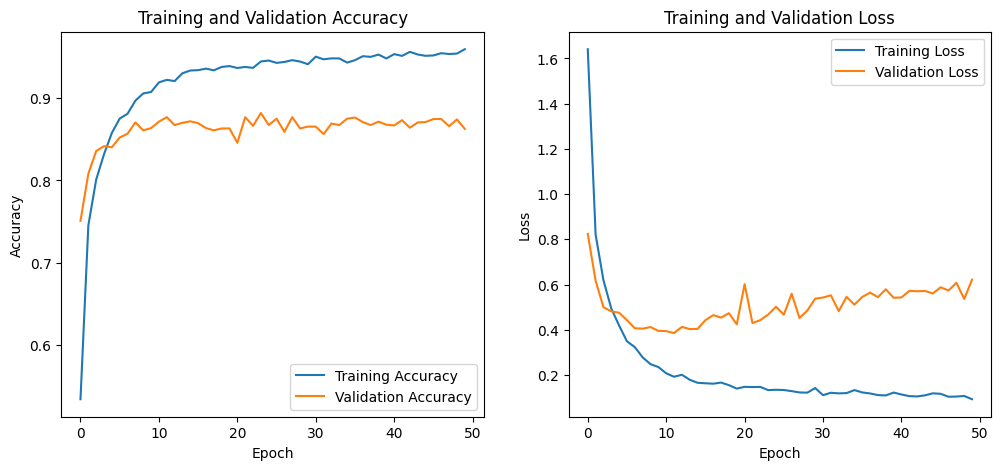

In [ ]:
# Visualisasi Hasil Pelatihan
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Penjelasan Visualisasi:

Plot Kiri: Training and Validation Accuracy

- Training Accuracy (Akurasi Pelatihan): Garis biru menunjukkan bagaimana akurasi pada data pelatihan meningkat seiring berjalannya waktu (epoch). Biasanya, akurasi pelatihan akan terus meningkat seiring model belajar dari data.

- Validation Accuracy (Akurasi Validasi): Garis oranye menunjukkan akurasi model pada data validasi. Model yang baik akan menunjukkan akurasi validasi yang stabil atau meningkat, mencerminkan kemampuan model untuk menggeneralisasi pada data yang belum pernah dilihat sebelumnya.

Jika akurasi validasi mulai turun atau tidak meningkat, itu mungkin tanda overfitting, di mana model terlalu menyesuaikan diri dengan data pelatihan dan gagal untuk menggeneralisasi pada data baru.

Plot Kanan: Training and Validation Loss

- Training Loss (Loss Pelatihan): Garis biru menunjukkan bagaimana loss (kerugian) pada data pelatihan berkurang seiring waktu. Loss yang lebih rendah menunjukkan bahwa model semakin baik dalam memprediksi data pelatihan.

- Validation Loss (Loss Validasi): Garis oranye menunjukkan loss pada data validasi. Seiring berjalannya waktu, validation loss yang rendah menunjukkan bahwa model mampu membuat prediksi yang baik pada data yang tidak dilatih.

Jika loss validasi tetap tinggi atau meningkat, meskipun training loss menurun, itu menandakan overfitting, yang berarti model terlalu "terlatih" pada data pelatihan dan tidak dapat menangani data validasi dengan baik.

# Evaluasi Model

In [ ]:
# Evaluasi Mendalam Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Untuk visualisasi confusion matrix
import matplotlib.image as mpimg

print("\n--- Evaluasi Mendalam Model ---")

# 1. Mengumpulkan Prediksi dan Label Sebenarnya dari Validation Set
y_true = []
y_pred_probs = [] # menyimpan probabilitas prediksi

for images, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
    img_batch = tf.expand_dims(images, axis=0)
    y_pred_probs.append(model.predict(img_batch)[0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # mengambil ideks prob tertinggi



--- Evaluasi Mendalam Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━

Pada bagian ini, kita mengumpulkan prediksi dan label sebenarnya dari dataset validasi. Kemudian, kita menghitung kelas dengan probabilitas tertinggi dari prediksi untuk setiap gambar. Langkah selanjutnya biasanya adalah evaluasi model menggunakan metrik seperti classification report dan confusion matrix, yang memberikan gambaran yang lebih mendalam tentang kinerja model dalam mengenali setiap kelas.

## Classification Report

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
                                                                      precision    recall  f1-score   support

   Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)       0.90      0.90      0.90        63
   Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)       0.16      0.18      0.17        60
      Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)       0.86      0.98      0.91        60
   Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)       0.09      0.08      0.09        60
          Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)       0.96      0.85      0.90        60
        Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)       0.88      0.82      0.84        60
     Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)       1.00      0.87      0.93        60
          Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)       0.98      0.98      

## Visualisasi Confusion Matrix


Membuat Confusion Matrix...


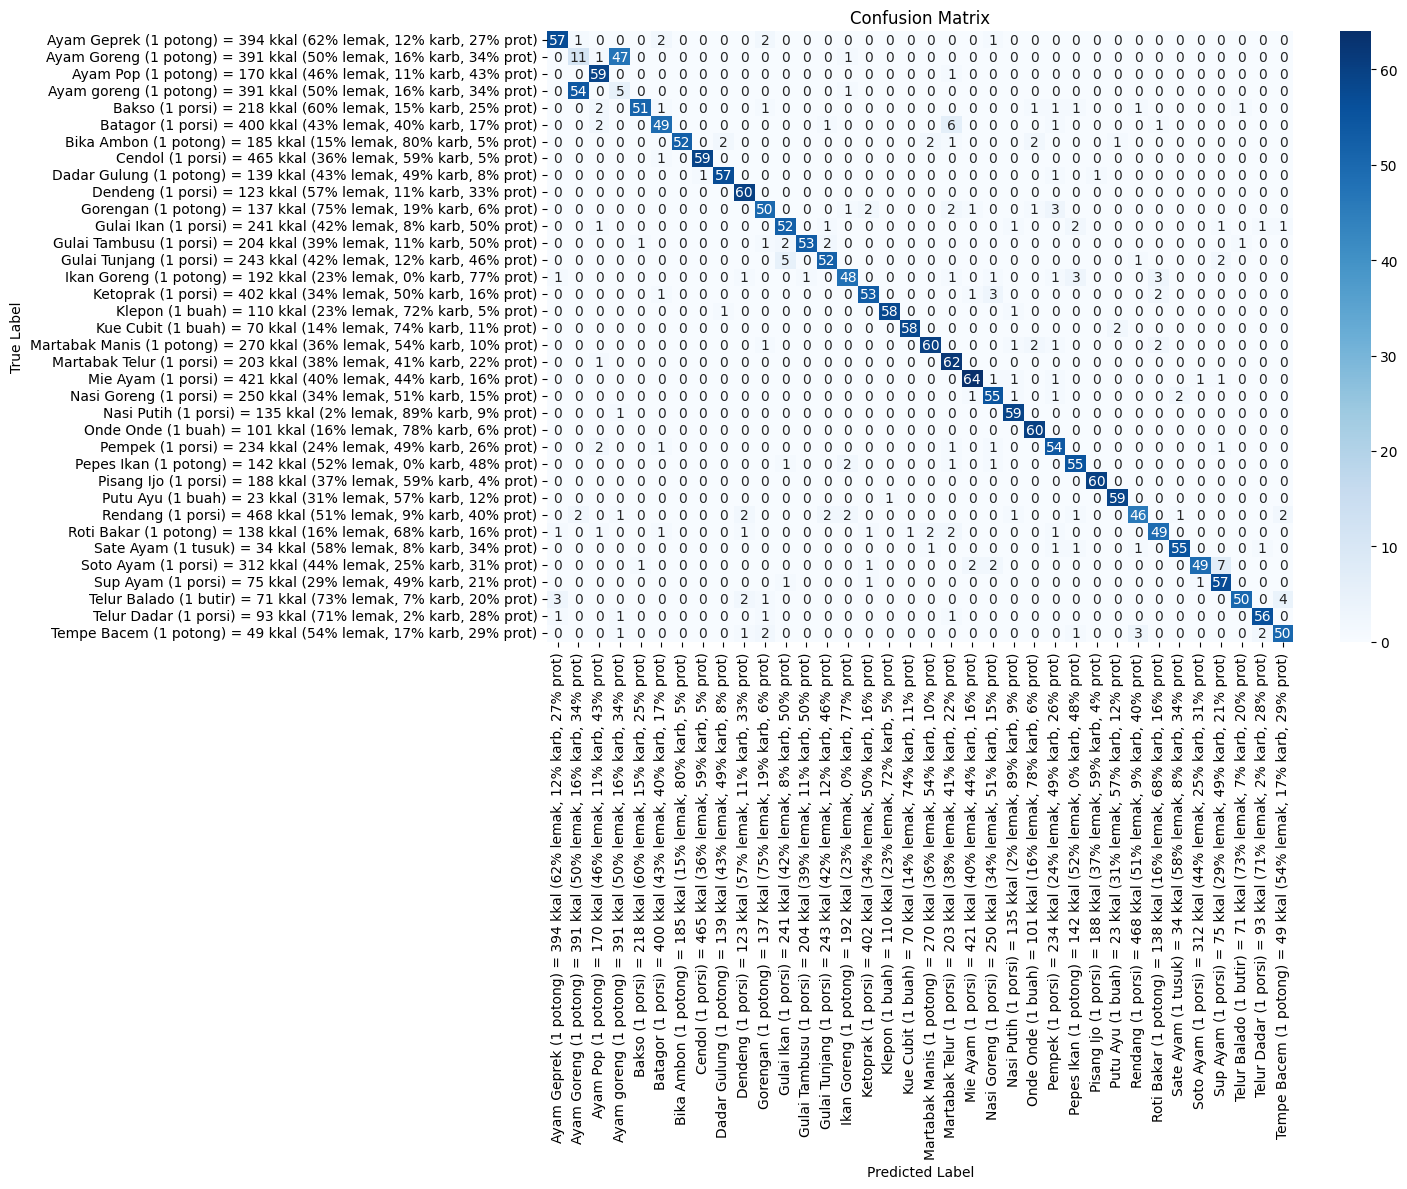

In [ ]:
# Visualisasi Confusion Matrix
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Confusion matrix ini memberikan gambaran tentang bagaimana model mengklasifikasikan data ke dalam berbagai kategori. Dengan memeriksa diagonal utama dan kesalahan prediksi yang terjadi di luar diagonal, kita bisa melihat sejauh mana model berhasil mengklasifikasikan gambar ke dalam kategori yang benar, serta area mana yang perlu perbaikan lebih lanjut.

## Menampilkan Contoh Kesalahan Model


--- Analisis Contoh Kesalahan ---
Mencari contoh gambar yang salah diklasifikasikan...
Ditemukan 300 gambar yang salah diklasifikasikan.


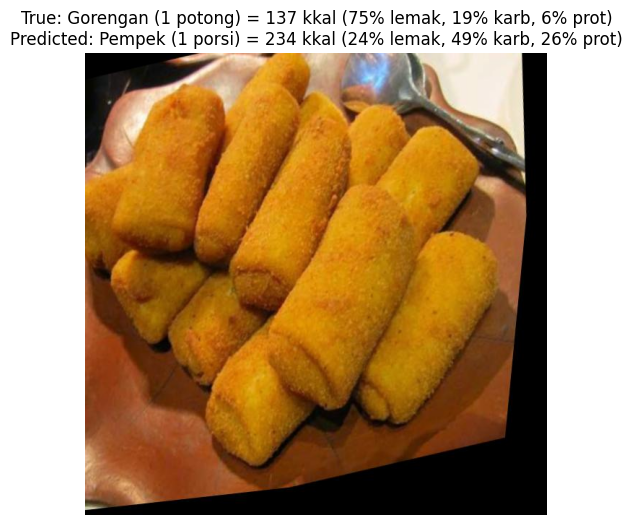

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot)/gorengan_85_jpg.rf.2be1851e6d07dfb2df528f30390d118d.jpg
True: Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot), Predicted: Pempek (1 porsi) = 234 kkal (24% lemak, 49% karb, 26% prot)



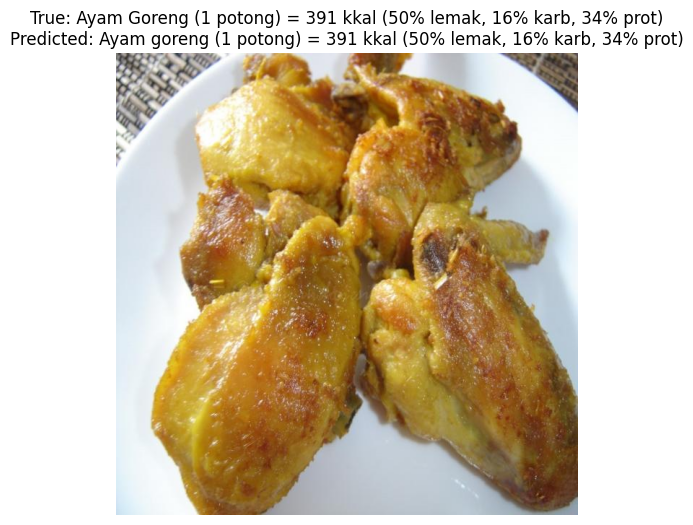

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)/ayam_goreng_14_jpg.rf.1c0c52f469afc775b6210d5d51a9b769.jpg
True: Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot), Predicted: Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)



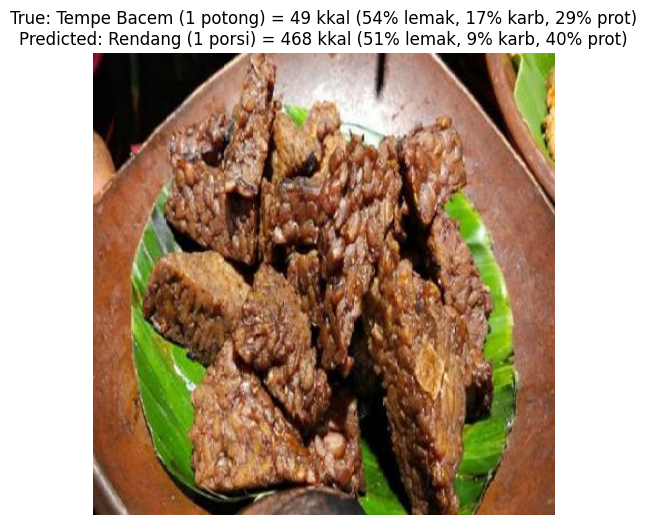

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot)/6_tempe_bacem_54_jpg.rf.8f2c6105cc23c64dbce23ac7539e3bfb.jpg
True: Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot), Predicted: Rendang (1 porsi) = 468 kkal (51% lemak, 9% karb, 40% prot)



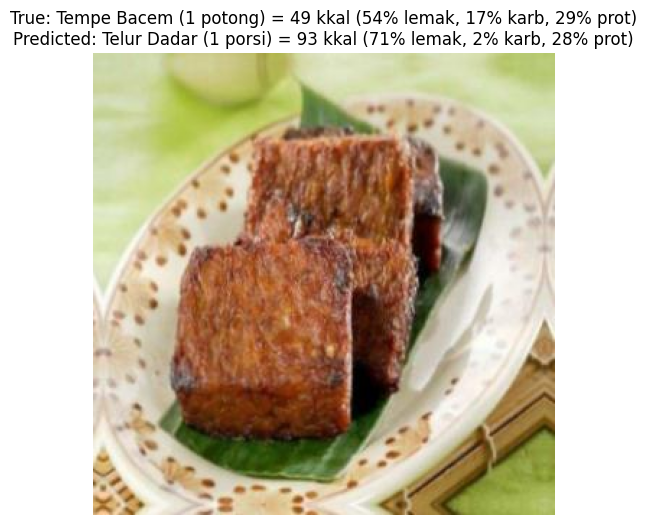

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot)/aug_62_6_tempe_bacem_92_jpg.rf.f60ec57156397e71a5bdfd12660d2aaa.jpg
True: Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot), Predicted: Telur Dadar (1 porsi) = 93 kkal (71% lemak, 2% karb, 28% prot)



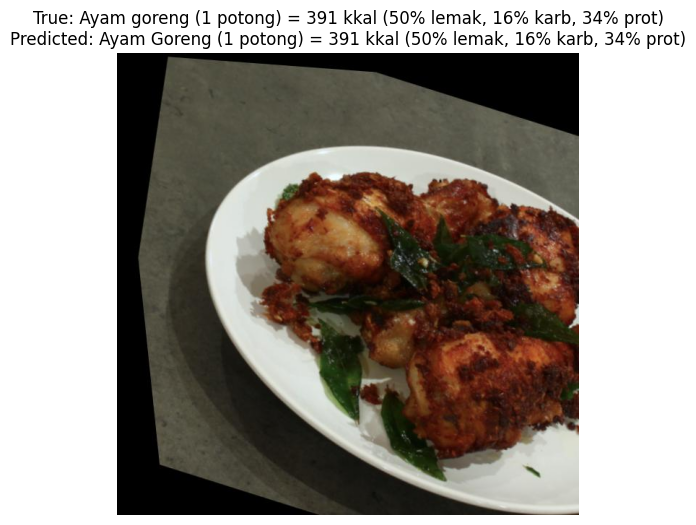

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)/ayam_goreng_2_png.rf.6afe883827e7568b77f3e532591bb375.jpg
True: Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot), Predicted: Ayam Goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)



In [ ]:
# Analisis Contoh Kesalahan ML
print("\n--- Analisis Contoh Kesalahan ---")
print("Mencari contoh gambar yang salah diklasifikasikan...")

# Dapatkan indeks gambar yang salah diklasifikasikan
misclassified_indices = np.where(y_true != y_pred_classes)[0]

if len(misclassified_indices) > 0:
    print(f"Ditemukan {len(misclassified_indices)} gambar yang salah diklasifikasikan.")
    # Tampilkan beberapa contoh
    num_display_errors = min(5, len(misclassified_indices)) # Tampilkan maksimal 5 kesalahan

    error_paths = []
    error_true_labels = []
    error_predicted_labels = []

    for i in range(num_display_errors):
        idx_in_val_set = misclassified_indices[i]
        original_path = val_paths[idx_in_val_set]
        true_label = class_names[y_true[idx_in_val_set]]
        predicted_label = class_names[y_pred_classes[idx_in_val_set]]

        plt.figure(figsize=(6, 6))
        img = mpimg.imread(original_path)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
        plt.show()
        print(f"Gambar: {original_path}\nTrue: {true_label}, Predicted: {predicted_label}\n")

else:
    print("Tidak ada gambar yang salah diklasifikasikan di validation set!")

## Menguji Model dan Melihat Persentase Keberhasilan

In [ ]:
# Menguji Model dan Melihat Persentase Keberhasilan
print(f"\nEvaluasi pada data validasi:")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Persentase Keberhasilan (Validation Accuracy): {val_accuracy*100:.2f}%")


Evaluasi pada data validasi:
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8786 - loss: 0.5374
Validation Loss: 0.6219
Persentase Keberhasilan (Validation Accuracy): 86.26%


## Menyimpan model

In [ ]:
# Menyimpan model dalam saved_model
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
# Menyimpan model dalam format h5
model.save('model.h5')

In [ ]:
# Menyimpan model dalam tensoflow.js
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve saved_model tfjs_model

2025-06-05 13:47:24.586077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749131244.834277   34411 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749131244.900886   34411 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-05 13:47:35.323275: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749131255.323466   34411 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
# Menyimpan model dalam tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Download model yang telah disimpan dalam berbagai format
!zip -r saved_model.zip saved_model
!zip -r model.h5.zip model.h5
!zip -r tfjs_model.zip tfjs_model
!zip -r model.tflite.zip model.tflite

from google.colab import files
files.download('saved_model.zip')
files.download('model.h5.zip')
files.download('tfjs_model.zip')
files.download('model.tflite.zip')

updating: saved_model/ (stored 0%)
updating: saved_model/saved_model.pb (deflated 92%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
updating: saved_model/variables/variables.index (deflated 77%)
updating: saved_model/fingerprint.pb (stored 0%)
  adding: model.h5 (deflated 11%)
updating: tfjs_model/ (stored 0%)
updating: tfjs_model/model.json (deflated 96%)
updating: tfjs_model/group1-shard1of3.bin (deflated 7%)
updating: tfjs_model/group1-shard2of3.bin (deflated 7%)
updating: tfjs_model/group1-shard3of3.bin (deflated 7%)
updating: model.tflite (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>